In [5]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 1)
        )

    def forward(self, x):
        return self.stack(x)


def dx(f, wrt, n):
    for i in range(n):
        grads = torch.autograd.grad(f, wrt, create_graph=True)[0]
        f = grads.sum()
    return grads

def ode_loss(x, y):
    assert(x.shape == y.shape)
    dy = dx(torch.sum(y), x, 1)
    dy2 = dx(torch.sum(y), x, 2)

    # A = torch.linalg.norm(5*dy+2*x*y, ord=2)
    # A = torch.linalg.norm(dy2 + 5*dy + 4*y, ord=2)
    A = torch.linalg.norm(10*dy2 + 5*y, ord=2)
    return A

def bound_loss(y, x):
    return torch.linalg.norm(y)
    return torch.linalg.norm(y-1, ord=2)
    
def bound_loss2(y, x):
    dy = dx(torch.sum(y), x, 1)
    # print(dy[0])
    return torch.linalg.norm(dy-1, ord=2)
    return torch.linalg.norm(dy+7, ord=2)


Using cpu device


In [3]:
model = NN()
model = model
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

k = 1
alph = 1
beta = 500

0 7901.21826171875 8.056000709533691 0.032183848321437836 15.786259651184082
500 7900.87744140625 7.713314533233643 0.014231845736503601 15.786299705505371


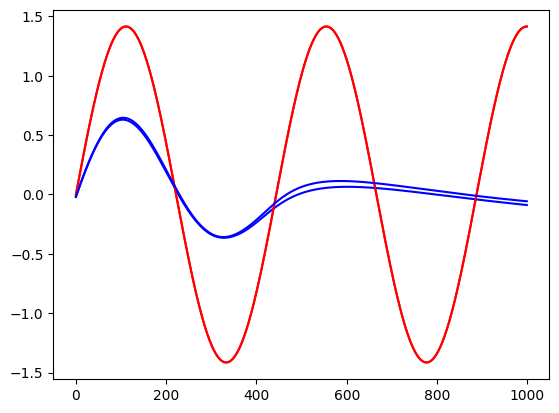

In [6]:
N = 250
X = torch.linspace(0, 20, N, requires_grad=True).reshape(N, 1)
X_test = torch.linspace(0, 20, 1000).reshape(1000, 1)
x = np.linspace(0, 20, 1000)

for e in range(0, 1000):
    optimizer.zero_grad()
    output = model(X)
    loss1 = ode_loss(X, output)
    output = model(X[0])
    # print(output)
    loss2 = bound_loss(output, X)
    loss3 = bound_loss2(output, X)
    loss = k*loss1 + alph*loss2 + beta*loss3
    loss.backward()
    optimizer.step()
    if e % 500 == 0:
        plt.plot(np.sqrt(2)*np.sin(x/np.sqrt(2)), color='r')
        plt.plot(model(X_test).detach(), color='b')
        print(e, loss.item(), loss1.item(), loss2.item(), loss3.item())

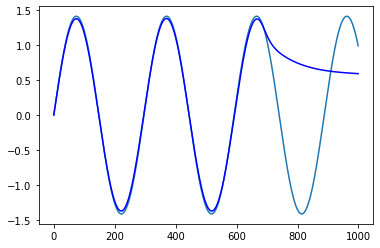

In [612]:
x = np.linspace(0, 30, 1000)
X_test = torch.linspace(0, 30, 1000).reshape(1000, 1)

# plt.plot(-np.exp(-x) + 2*np.exp(-4*x))
# plt.plot(1/9 * np.exp(-x/4) * (np.sqrt(15) * np.sin(3/4 * np.sqrt(3/5) * x) + 9 * np.cos(3/4 * np.sqrt(3/5) * x)))

plt.plot(np.sqrt(2)*np.sin(x/np.sqrt(2)))
plt.plot(model(X_test).detach(), color='b')

In [614]:
import pygame

pygame.init()
window = pygame.display.set_mode([800,600],pygame.RESIZABLE)
clock = pygame.time.Clock()
game_running = True 


x = 0
while game_running :
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            print("closing the game")
            game_running = False
            break
    window.fill((0, 0, 0))
    # print(model(torch.Tensor([x])).item())
    pygame.draw.circle(window, (255, 255, 255), (500 + 100*model(torch.Tensor([x])).item(), 100), 10)
    pygame.display.update()
    x+=.001


pygame.quit()

closing the game
